In [89]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os

import IPython.display as ipd

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,precision_recall_curve
from sklearn.metrics import precision_recall_fscore_support,f1_score,fbeta_score
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.utils import shuffle

import librosa
import librosa.display
import ast

import keras
plt.rcParams['figure.figsize'] = (17, 5)



In [90]:
df = pd.read_csv('data.csv')

In [91]:
df.head()

,filename,chroma_cqt,chroma_cens,chroma_stft,spectral_centroid,spectral_bandwidth,spectral_contrast,rolloff,zero_crossing_rate,tonnetz,...,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
0,126014,0.267008,0.171130,0.237383,699.229710,785.999971,25.676751,1183.751175,0.041712,0.092841,...,-27.326481,-20.607473,-12.659972,-13.275584,-12.988043,-15.687397,-12.339302,2.211766,2.147864,-5.011512
1,54496,0.274600,0.207362,0.277710,1833.074733,2091.124342,25.274995,3818.560243,0.093890,0.044640,...,-5.424025,6.843907,-6.247772,3.441898,-0.244973,4.090439,-1.278771,9.071951,-0.169724,0.161876
2,65893,0.458305,0.253559,0.412075,2767.487106,2741.112704,20.450162,5889.689386,0.111506,0.013648,...,-8.586940,6.649025,-2.908488,3.085722,-3.682684,2.957125,-2.243021,1.578797,-4.537785,1.052801
3,71158,0.531325,0.258276,0.424391,1444.225428,2060.084462,19.861984,3089.631317,0.046734,0.000029,...,5.303405,-0.030636,-1.089045,2.822888,-2.630777,1.943587,-7.131413,1.516889,-0.094114,-0.776687
4,57821,0.412456,0.239312,0.335196,2253.305912,2412.719760,22.327731,4858.028957,0.099870,0.024816,...,-8.056653,-5.495337,-8.891809,-2.783748,-6.777088,-3.736772,-11.871335,-0.826213,-2.934075,6.011378


In [92]:
df.shape

(7997, 30)

In [93]:
genres = pd.read_csv('data/fma_metadata/genrelist.csv')

In [94]:
genres

,Unnamed: 0,genre,testtrainval
0,NaN,NaN,NaN
1,track_id,NaN,NaN
2,2,Hip-Hop,training
3,5,Hip-Hop,training
4,10,Pop,training
...,...,...,...
7997,154308,Hip-Hop,test
7998,154309,Hip-Hop,test
7999,154413,Pop,training
8000,154414,Pop,training


In [95]:
genres.rename({'Unnamed: 0':'track_id'},axis=1,inplace=True)

In [96]:
genres = genres.drop(index=[0,1])

In [97]:
genres.head()

,track_id,genre,testtrainval
2,2,Hip-Hop,training
3,5,Hip-Hop,training
4,10,Pop,training
5,140,Folk,training
6,141,Folk,training


In [98]:
genres['track_id'] = genres['track_id'].astype('int64')

In [99]:
df.rename({'filename':'track_id'},axis=1,inplace=True)

In [100]:
df['track_id']

0       126014
1        54496
2        65893
3        71158
4        57821
         ...  
7992     43695
7993     68410
7994     51291
7995     96902
7996     75441
Name: track_id, Length: 7997, dtype: int64

In [101]:
data=pd.merge(df,genres,on='track_id')

In [102]:
data['genre']

0        Instrumental
1        Experimental
2                Folk
3             Hip-Hop
4             Hip-Hop
            ...      
7992    International
7993     Experimental
7994              Pop
7995     Experimental
7996     Instrumental
Name: genre, Length: 7997, dtype: object

In [103]:
data.set_index('track_id',inplace=True)

In [104]:
data.head()

,chroma_cqt,chroma_cens,chroma_stft,spectral_centroid,spectral_bandwidth,spectral_contrast,rolloff,zero_crossing_rate,tonnetz,mfcc1,...,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,genre,testtrainval
track_id,,,,,,,,,,,,,,,,,,,,,
126014,0.267008,0.171130,0.237383,699.229710,785.999971,25.676751,1183.751175,0.041712,0.092841,-352.161438,...,-12.659972,-13.275584,-12.988043,-15.687397,-12.339302,2.211766,2.147864,-5.011512,Instrumental,training
54496,0.274600,0.207362,0.277710,1833.074733,2091.124342,25.274995,3818.560243,0.093890,0.044640,-290.169464,...,-6.247772,3.441898,-0.244973,4.090439,-1.278771,9.071951,-0.169724,0.161876,Experimental,training
65893,0.458305,0.253559,0.412075,2767.487106,2741.112704,20.450162,5889.689386,0.111506,0.013648,-80.027184,...,-2.908488,3.085722,-3.682684,2.957125,-2.243021,1.578797,-4.537785,1.052801,Folk,training
71158,0.531325,0.258276,0.424391,1444.225428,2060.084462,19.861984,3089.631317,0.046734,0.000029,-123.564980,...,-1.089045,2.822888,-2.630777,1.943587,-7.131413,1.516889,-0.094114,-0.776687,Hip-Hop,training
57821,0.412456,0.239312,0.335196,2253.305912,2412.719760,22.327731,4858.028957,0.099870,0.024816,-71.340874,...,-8.891809,-2.783748,-6.777088,-3.736772,-11.871335,-0.826213,-2.934075,6.011378,Hip-Hop,training


In [138]:
y = data[['genre']]

In [139]:
X = data.drop(['genre','testtrainval'],axis=1)

In [140]:
X

,chroma_cqt,chroma_cens,chroma_stft,spectral_centroid,spectral_bandwidth,spectral_contrast,rolloff,zero_crossing_rate,tonnetz,mfcc1,...,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
track_id,,,,,,,,,,,,,,,,,,,,,
126014,0.267008,0.171130,0.237383,699.229710,785.999971,25.676751,1183.751175,0.041712,0.092841,-352.161438,...,-27.326481,-20.607473,-12.659972,-13.275584,-12.988043,-15.687397,-12.339302,2.211766,2.147864,-5.011512
54496,0.274600,0.207362,0.277710,1833.074733,2091.124342,25.274995,3818.560243,0.093890,0.044640,-290.169464,...,-5.424025,6.843907,-6.247772,3.441898,-0.244973,4.090439,-1.278771,9.071951,-0.169724,0.161876
65893,0.458305,0.253559,0.412075,2767.487106,2741.112704,20.450162,5889.689386,0.111506,0.013648,-80.027184,...,-8.586940,6.649025,-2.908488,3.085722,-3.682684,2.957125,-2.243021,1.578797,-4.537785,1.052801
71158,0.531325,0.258276,0.424391,1444.225428,2060.084462,19.861984,3089.631317,0.046734,0.000029,-123.564980,...,5.303405,-0.030636,-1.089045,2.822888,-2.630777,1.943587,-7.131413,1.516889,-0.094114,-0.776687
57821,0.412456,0.239312,0.335196,2253.305912,2412.719760,22.327731,4858.028957,0.099870,0.024816,-71.340874,...,-8.056653,-5.495337,-8.891809,-2.783748,-6.777088,-3.736772,-11.871335,-0.826213,-2.934075,6.011378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43695,0.355867,0.211697,0.199330,1886.972897,1661.104670,23.935287,3260.813616,0.120591,0.059061,-43.920574,...,9.848370,17.061972,2.227302,-2.029427,-8.724811,2.876313,-2.736481,-2.547942,-10.971077,-4.219173
68410,0.377441,0.246737,0.307813,2865.321706,2878.870789,19.031659,6273.395399,0.114266,0.051395,-16.044903,...,-4.045043,0.901013,-8.597396,-5.432930,-12.551827,-5.137374,-5.069657,1.975084,-0.862782,-1.661779
51291,0.546975,0.267928,0.402148,2544.940958,1948.868546,20.836240,4248.374311,0.168549,0.018364,-129.250885,...,0.234382,4.351338,-6.455239,-0.917210,-7.075034,-6.199870,-16.941978,-10.509199,-13.883102,-8.334950


In [141]:
X_train, X_test, y_train , y_test = train_test_split(X,y,stratify=y,test_size=0.15)

In [142]:
X_train,X_val, y_train, y_val = train_test_split(X_train,y_train, stratify=y_train,test_size=0.18)

In [143]:
X_train.shape, X_test.shape, X_val.shape

((5573, 29), (1200, 29), (1224, 29))

In [111]:
encoder = LabelEncoder()

In [145]:
from sklearn.preprocessing import OneHotEncoder

In [146]:
ohe = OneHotEncoder()

In [147]:
y_train = ohe.fit_transform(y_train)
y_test = ohe.transform(y_test)
y_val = ohe.transform(y_val)

In [112]:
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)
y_val = encoder.transform(y_val)

In [113]:
scaler = StandardScaler()

In [114]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [125]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(29, activation='relu', input_shape=(X_train.shape[1],)))

model.add(layers.Dense(25, activation='relu'))

model.add(layers.Dense(25, activation='relu'))

model.add(layers.Dense(8, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train,
                    y_train,
                    epochs=50,
                    batch_size=50)

ValueError: Unknown loss function:crossentropy

In [87]:
test_loss, test_acc = model.evaluate(X_test,y_test)
print('test_acc: ',test_acc)

1200/1200 [==============================] - 0s 234us/step
test_acc:  0.45


In [118]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(100, activation='relu', input_shape=(X_train.shape[1],)))

model.add(layers.Dense(150, activation='relu'))

model.add(layers.Dense(60, activation='relu'))

model.add(layers.Dense(8, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train,
                    y_train,
                    epochs=50,
                    batch_size=32)

Epoch 1/50
5573/5573 [==============================] - 1s 180us/step - loss: 1.7175 - acc: 0.3765
Epoch 2/50
5573/5573 [==============================] - 0s 42us/step - loss: 1.5288 - acc: 0.4513
Epoch 3/50
5573/5573 [==============================] - 0s 42us/step - loss: 1.4578 - acc: 0.4784
Epoch 4/50
5573/5573 [==============================] - 0s 42us/step - loss: 1.4067 - acc: 0.4897
Epoch 5/50
5573/5573 [==============================] - 0s 43us/step - loss: 1.3527 - acc: 0.5089
Epoch 6/50
5573/5573 [==============================] - 0s 42us/step - loss: 1.3095 - acc: 0.5338
Epoch 7/50
5573/5573 [==============================] - 0s 43us/step - loss: 1.2670 - acc: 0.5491
Epoch 8/50
5573/5573 [==============================] - 0s 44us/step - loss: 1.2154 - acc: 0.5670
Epoch 9/50
5573/5573 [==============================] - 0s 42us/step - loss: 1.1818 - acc: 0.5837
Epoch 10/50
5573/5573 [==============================] - 0s 43us/step - loss: 1.1320 - acc: 0.5990
Epoch 11/50
5573/5

In [119]:
test_loss, test_acc = model.evaluate(X_test,y_test)
print('test_acc: ',test_acc)

1200/1200 [==============================] - 0s 296us/step
test_acc:  0.43833333333333335


In [111]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X2_train.shape[1],)))

model.add(layers.Dense(128, activation='relu'))

model.add(layers.Dense(64, activation='relu'))

model.add(layers.Dense(8, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X2_train,
                    y_train,
                    epochs=50,
                    batch_size=32)

Epoch 1/50
6397/6397 [==============================] - 0s 72us/step - loss: 1.7764 - acc: 0.3444
Epoch 2/50
6397/6397 [==============================] - 0s 37us/step - loss: 1.6170 - acc: 0.4136
Epoch 3/50
6397/6397 [==============================] - 0s 40us/step - loss: 1.5614 - acc: 0.4332
Epoch 4/50
6397/6397 [==============================] - 0s 38us/step - loss: 1.5136 - acc: 0.4596
Epoch 5/50
6397/6397 [==============================] - 0s 37us/step - loss: 1.4722 - acc: 0.4705
Epoch 6/50
6397/6397 [==============================] - 0s 38us/step - loss: 1.4307 - acc: 0.4785
Epoch 7/50
6397/6397 [==============================] - 0s 38us/step - loss: 1.3911 - acc: 0.4990
Epoch 8/50
6397/6397 [==============================] - 0s 38us/step - loss: 1.3463 - acc: 0.5165
Epoch 9/50
6397/6397 [==============================] - 0s 37us/step - loss: 1.3060 - acc: 0.5335
Epoch 10/50
6397/6397 [==============================] - 0s 37us/step - loss: 1.2523 - acc: 0.5515
Epoch 11/50
6397/63

In [112]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X2_train.shape[1],)))

model.add(layers.Dense(128, activation='relu'))

model.add(layers.Dense(64, activation='relu'))

model.add(layers.Dense(8, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X2_train,
          y_train,
          epochs=30,
          batch_size=32,
          validation_data=(X2_val, y_val))
results = model.evaluate(X2_test, y_test)

Train on 6397 samples, validate on 800 samples
Epoch 1/30
6397/6397 [==============================] - 1s 82us/step - loss: 1.7392 - acc: 0.3600 - val_loss: 1.6929 - val_acc: 0.3550
Epoch 2/30
6397/6397 [==============================] - 0s 41us/step - loss: 1.5970 - acc: 0.4239 - val_loss: 1.6673 - val_acc: 0.3638
Epoch 3/30
6397/6397 [==============================] - 0s 40us/step - loss: 1.5425 - acc: 0.4461 - val_loss: 1.6806 - val_acc: 0.3800
Epoch 4/30
6397/6397 [==============================] - 0s 40us/step - loss: 1.4866 - acc: 0.4744 - val_loss: 1.7170 - val_acc: 0.3600
Epoch 5/30
6397/6397 [==============================] - 0s 40us/step - loss: 1.4442 - acc: 0.4868 - val_loss: 1.7634 - val_acc: 0.3550
Epoch 6/30
6397/6397 [==============================] - 0s 40us/step - loss: 1.3929 - acc: 0.5023 - val_loss: 1.7266 - val_acc: 0.3613
Epoch 7/30
6397/6397 [==============================] - 0s 41us/step - loss: 1.3495 - acc: 0.5143 - val_loss: 1.7949 - val_acc: 0.3563
Epoch 8/

In [222]:
results


[3.8182234287261965, 0.34]

In [44]:
model_1 = models.Sequential()
model_1.add(layers.Dense(5, activation='tanh', input_shape=(29,)))
model_1.add(layers.Dense(8, activation='sigmoid'))

In [46]:
model_1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [49]:
results_1 = model_1.fit(X_train,
          y_train,
          epochs=30,
          batch_size=32,
          validation_data=(X_val, y_val))

Train on 5573 samples, validate on 1224 samples
Epoch 1/30
5573/5573 [==============================] - 0s 34us/step - loss: 1.5968 - acc: 0.4098 - val_loss: 1.6372 - val_acc: 0.3881
Epoch 2/30
5573/5573 [==============================] - 0s 31us/step - loss: 1.5933 - acc: 0.4098 - val_loss: 1.6348 - val_acc: 0.3905
Epoch 3/30
5573/5573 [==============================] - 0s 30us/step - loss: 1.5905 - acc: 0.4107 - val_loss: 1.6323 - val_acc: 0.3930
Epoch 4/30
5573/5573 [==============================] - 0s 32us/step - loss: 1.5879 - acc: 0.4143 - val_loss: 1.6319 - val_acc: 0.3938
Epoch 5/30
5573/5573 [==============================] - 0s 31us/step - loss: 1.5855 - acc: 0.4123 - val_loss: 1.6289 - val_acc: 0.3938
Epoch 6/30
5573/5573 [==============================] - 0s 31us/step - loss: 1.5831 - acc: 0.4138 - val_loss: 1.6277 - val_acc: 0.3971
Epoch 7/30
5573/5573 [==============================] - 0s 31us/step - loss: 1.5804 - acc: 0.4163 - val_loss: 1.6249 - val_acc: 0.3954
Epoch 8

In [120]:
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_acc'])
    plt.plot(history['acc'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

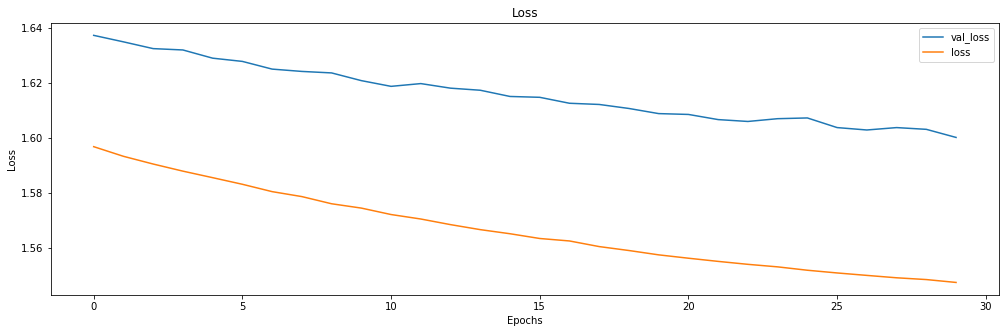

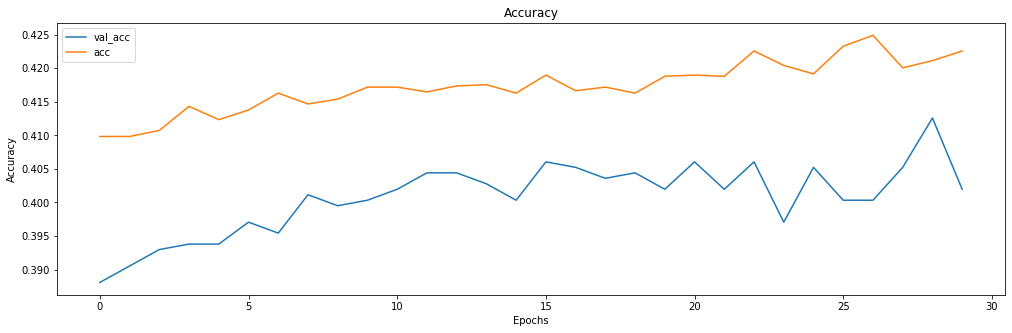

In [121]:
visualize_training_results(results_1)


In [122]:
results_1 = model_1.fit(X_train,
          y_train,
          epochs=30,
          batch_size=32,
          validation_data=(X_val, y_val))

Train on 5573 samples, validate on 1224 samples
Epoch 1/30
5573/5573 [==============================] - 0s 42us/step - loss: 1.5372 - acc: 0.4274 - val_loss: 1.5625 - val_acc: 0.4191
Epoch 2/30
5573/5573 [==============================] - 0s 36us/step - loss: 1.5353 - acc: 0.4265 - val_loss: 1.5615 - val_acc: 0.4199
Epoch 3/30
5573/5573 [==============================] - 0s 42us/step - loss: 1.5330 - acc: 0.4324 - val_loss: 1.5682 - val_acc: 0.4175
Epoch 4/30
5573/5573 [==============================] - 0s 36us/step - loss: 1.5327 - acc: 0.4314 - val_loss: 1.5653 - val_acc: 0.4248
Epoch 5/30
5573/5573 [==============================] - 0s 38us/step - loss: 1.5318 - acc: 0.4319 - val_loss: 1.5658 - val_acc: 0.4265
Epoch 6/30
5573/5573 [==============================] - 0s 37us/step - loss: 1.5315 - acc: 0.4324 - val_loss: 1.5675 - val_acc: 0.4224
Epoch 7/30
5573/5573 [==============================] - 0s 37us/step - loss: 1.5312 - acc: 0.4339 - val_loss: 1.5680 - val_acc: 0.4167
Epoch 8

In [123]:
model_2 = models.Sequential()
model_2.add(layers.Dense(30, activation='tanh', input_shape=(29,)))
model_2.add(layers.Dense(20, activation='tanh'))
model_2.add(layers.Dense(14, activation='relu'))
model_2.add(layers.Dense(14, activation='tanh'))
model_2.add(layers.Dense(8, activation='sigmoid'))

model_2.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
results_2 = model_2.fit(X_train,
          y_train,
          epochs=15,
          batch_size=1,
          validation_data=(X_val, y_val))

# results_2 = model_2.fit(X_train, y_train, epochs=25, batch_size=1, validation_data=(X_val, y_val))

Train on 5573 samples, validate on 1224 samples
Epoch 1/15
5573/5573 [==============================] - 9s 2ms/step - loss: 1.7843 - acc: 0.3361 - val_loss: 1.7192 - val_acc: 0.3725
Epoch 2/15
5573/5573 [==============================] - 8s 1ms/step - loss: 1.6233 - acc: 0.4070 - val_loss: 1.6391 - val_acc: 0.4093
Epoch 3/15
5573/5573 [==============================] - 8s 1ms/step - loss: 1.5688 - acc: 0.4283 - val_loss: 1.6542 - val_acc: 0.3954
Epoch 4/15
5573/5573 [==============================] - 8s 1ms/step - loss: 1.5339 - acc: 0.4452 - val_loss: 1.6171 - val_acc: 0.4126
Epoch 5/15
5573/5573 [==============================] - 8s 1ms/step - loss: 1.5068 - acc: 0.4543 - val_loss: 1.6163 - val_acc: 0.4265
Epoch 6/15
5573/5573 [==============================] - 8s 1ms/step - loss: 1.4779 - acc: 0.4698 - val_loss: 1.5853 - val_acc: 0.4346
Epoch 7/15
5573/5573 [==============================] - 8s 1ms/step - loss: 1.4574 - acc: 0.4812 - val_loss: 1.6134 - val_acc: 0.4297
Epoch 8/15
557

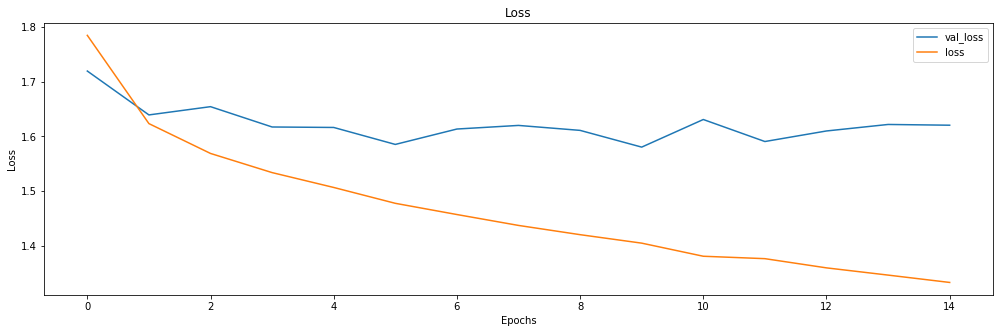

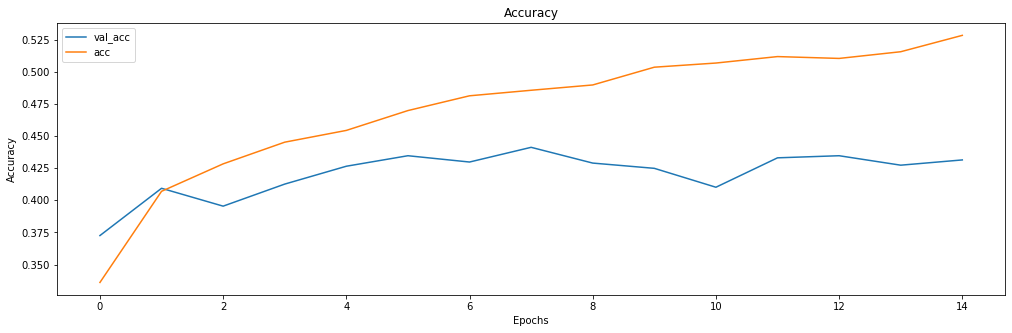

In [124]:
visualize_training_results(results_2)


In [130]:
y_train.unique()

AttributeError: 'numpy.ndarray' object has no attribute 'unique'

In [ ]:
model.add(layers.Dense(units, activation, input_shape))


In [ ]:
model.add(layers.Dense(29, activation='relu', input_shape=(X_train.shape[1],)))


In [134]:
X_train.shape

(5573, 29)

In [151]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(29, activation='relu', input_shape=(X_train.shape[1],)))

model.add(layers.Dense(25, activation='relu'))

model.add(layers.Dense(25, activation='relu'))

model.add(layers.Dense(8, activation='softmax'))

model.compile(optimizer='adam',
              loss='ategorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train,
                    y_train,
                    epochs=50,
                    batch_size=50)

ValueError: Unknown loss function:ategorical_crossentropy